Nama : Amrul Fadhil Yofan

Dataset : https://www.kaggle.com/datasets/chaoquntan/image-dataset-of-zanthoxyli-pericarpium

Source : Kaggle

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
import os, glob
import PIL
from tensorflow.keras import layers
from keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import DenseNet201, Xception
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split

## Import Dataset dari Kaggle

In [2]:
!pip install -q kaggle

In [3]:
# Upload kaggle.json secara manual
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amrulfy","key":"8ec629e82333ebf8f0418507351abeda"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [5]:
# Download dataset
!kaggle datasets download -d chaoquntan/image-dataset-of-zanthoxyli-pericarpium

 99% 1.98G/1.99G [00:24<00:00, 125MB/s]
100% 1.99G/1.99G [00:24<00:00, 88.5MB/s]


In [6]:
# Unzip dan lihat list dataset
!mkdir zp
!unzip image-dataset-of-zanthoxyli-pericarpium.zip -d zp
!ls zp

Streaming output truncated to the last 5000 lines.
  inflating: zp/pictures/4hong_hanyuan/4108.jpg  
  inflating: zp/pictures/4hong_hanyuan/4109.jpg  
  inflating: zp/pictures/4hong_hanyuan/411 - тХХтЦТтЦТтХЫ.jpg  
  inflating: zp/pictures/4hong_hanyuan/411.jpg  
  inflating: zp/pictures/4hong_hanyuan/4110.jpg  
  inflating: zp/pictures/4hong_hanyuan/4111.jpg  
  inflating: zp/pictures/4hong_hanyuan/4112.jpg  
  inflating: zp/pictures/4hong_hanyuan/4113.jpg  
  inflating: zp/pictures/4hong_hanyuan/4114.jpg  
  inflating: zp/pictures/4hong_hanyuan/4115.jpg  
  inflating: zp/pictures/4hong_hanyuan/4116.jpg  
  inflating: zp/pictures/4hong_hanyuan/4117.jpg  
  inflating: zp/pictures/4hong_hanyuan/4118.jpg  
  inflating: zp/pictures/4hong_hanyuan/4119.jpg  
  inflating: zp/pictures/4hong_hanyuan/412 - тХХтЦТтЦТтХЫ.jpg  
  inflating: zp/pictures/4hong_hanyuan/412.jpg  
  inflating: zp/pictures/4hong_hanyuan/4120.jpg  
  inflating: zp/pictures/4hong_hanyuan/4121.jpg  
  inflating: zp/picture

## Split Data dan Augmentasi Gambar

In [7]:
data = '/content/zp/pictures'

hong_sichuan = [img for img in os.listdir(f'{data}/0hong_sichuan') if img.endswith('.jpg')]
qing_qingjiao = [img for img in os.listdir(f'{data}/1qing_qingjiao') if img.endswith('.jpg')]
qing_tengjiao = [img for img in os.listdir(f'{data}/2qing_tengjiao') if img.endswith('.jpg')]
hong_derong = [img for img in os.listdir(f'{data}/3hong_derong') if img.endswith('.jpg')]
hong_hanyuan = [img for img in os.listdir(f'{data}/4hong_hanyuan') if img.endswith('.jpg')]

zp = [hong_sichuan, qing_qingjiao, qing_tengjiao, hong_derong, hong_hanyuan]
zp_classes = []

for i in os.listdir(data):
  zp_classes+=[i]
zp_classes.sort()

data_dir = pathlib.Path(data).with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Total gambar: {image_count}')
print(f'Total kelas: {len(zp_classes)}')
count = 0
zp_count = []
for i in zp_classes:
  print(f'Total gambar di {i} : {len(zp[count])}')
  zp_count.append(len(zp[count]))
  count += 1

Total gambar: 71051
Total kelas: 5
Total gambar di 0hong_sichuan : 18008
Total gambar di 1qing_qingjiao : 14027
Total gambar di 2qing_tengjiao : 16313
Total gambar di 3hong_derong : 12223
Total gambar di 4hong_hanyuan : 10480


In [8]:
!ls zp/pictures

0hong_sichuan  1qing_qingjiao  2qing_tengjiao  3hong_derong  4hong_hanyuan


Total ada  5 jenis gambar untuk proses konstruksi model klasifikasi gambar.

In [18]:
# Membagi data utama menjadi dua data
datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data,
    target_size=(150, 150),
    batch_size=16,
    shuffle=True,
    subset='training',
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    data,
    target_size=(150, 150),
    batch_size=16,
    shuffle=False,
    subset='validation',
    class_mode='categorical'
)

Found 56939 images belonging to 5 classes.
Found 14232 images belonging to 5 classes.


In [19]:
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 150, 150, 3)
(16, 5)


Dari ukuran pembagian data validasi 20% dari total dataset, diperoleh:
- Data training memiliki 56939 sampel gambar dengan 5 class,

- Data validasi memiliki 14232 sampel gambar dengan 5 class.

Setelah data telah siap, dibentuk model arsitektur Convolutional Neural Network (CNN).

## Pembentukan Model Sequential

In [20]:
model = tf.keras.models.Sequential([
    DenseNet201(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding = 'same'),
    tf.keras.layers.MaxPool2D((2,2), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.layers[0].trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 128)         2211968   
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 2, 128)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                      

## Compile Model serta Menentukan Loss Function dan Optimizer

Dalam hal ini, dibentuk class **callback** untuk mencegah overfitting dan menghentikan training setelah syarat batas akurasi maksimum terpenuhi. Dipilih batas akurasi maksimum adalah 0.92.

In [21]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92):
      print("\nAkurasi melewati 92%, hentikan proses training!")
      self.model.stop_training = True

callbacks = myCallback()

Dipilih *compile* model dengan *optimizer* = 'Adam' dan *loss function* = 'categorical_crossentropy'

Keterangan : *loss function* pada kasus klasifikasi 5 class menggunakan 'categorical_crossentropy'.

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator,
    callbacks=[callbacks]
)

Epoch 1/10
3559/3559 [==============================] - 6553s 2s/step - loss: 0.3666 - accuracy: 0.8724 - val_loss: 0.2772 - val_accuracy: 0.9047
Epoch 2/10
3559/3559 [==============================] - 6550s 2s/step - loss: 0.2571 - accuracy: 0.9113 - val_loss: 0.2905 - val_accuracy: 0.9127
Epoch 3/10
3559/3559 [==============================] - 6530s 2s/step - loss: 0.2275 - accuracy: 0.9223 - val_loss: 0.2510 - val_accuracy: 0.9186
Epoch 4/10
3559/3559 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 0.9300
Akurasi melewati 92%, hentikan proses training!
3559/3559 [==============================] - 6575s 2s/step - loss: 0.2040 - accuracy: 0.9300 - val_loss: 0.2081 - val_accuracy: 0.9316


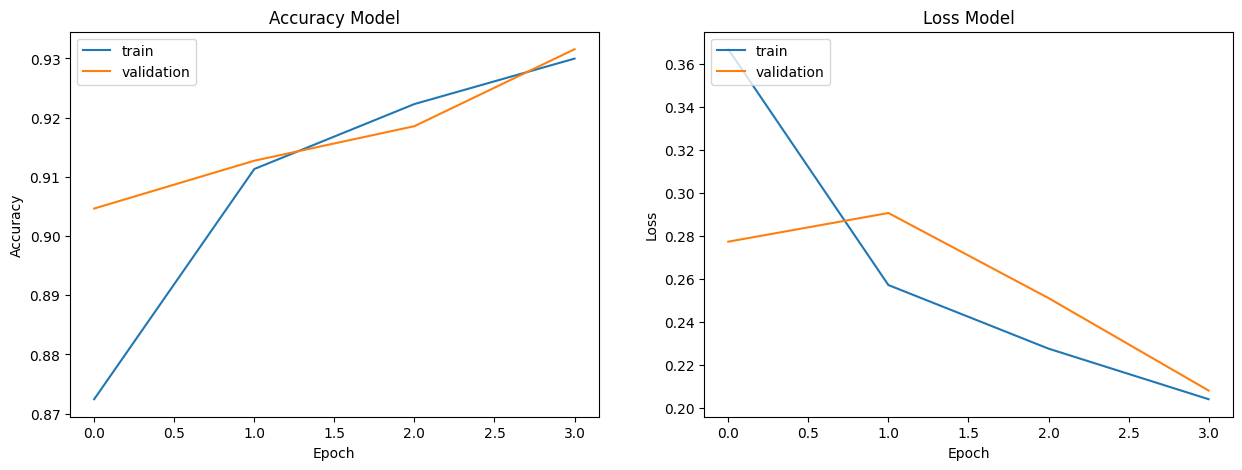

In [25]:
plt.figure(figsize=(15,5))

# Grafik Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')

# Grafik Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

In [26]:
# Save to TFLite Format
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

82680236